## Introduction

Since our dataset contains zip code and state information, we wanted to learn if there is any correlation between geographic location and any of the other features in the dataset. I obtained an external dataset with longitude, latitude, and US zip codes and merged it with our lending club dataset to visualized how different features geographically compare between each data point. I graphed annual income, loan amount, homeowner ship, and loan status based on the geographic location of the data points to learn any insight into how location might correlate with individual’s loan status.

In [109]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingClassifier

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#import the cleaned dataset and US zip codes with longitude and latitude
df = pd.read_csv("clean_lending_dataset.csv")
df_add = pd.read_excel("US-addresses.xlsx")

In [110]:
addy_df = df_add.loc[:, ['Zip', 'Latitude', 'Longitude', 'State']]
addy_df['Zip'] = addy_df['Zip'].astype('str')
addy_df['zip_code'] = addy_df['Zip'].str.slice(start =0, stop = 3)
state_df = addy_df.loc[:,['State', 'zip_code']]
state_df['zip_code'] = state_df['zip_code'].astype('int64')
addy_df = addy_df.drop(['Zip'], axis = 1)
addy_df = addy_df.groupby('zip_code').mean()
addy_df = addy_df.reset_index()
addy_df['zip_code'] = addy_df['zip_code'].astype('int64')

In [111]:
merged_df = df.merge(right = addy_df, right_on = 'zip_code', left_on = 'zip_code', how = 'left')
merged_df = merged_df.dropna()
merged_df.head()


,Unnamed: 0,emp_title,loan_amnt,funded_amnt,funded_amnt_inv,installment,int_rate,annual_inc,tot_hi_cred_lim,chargeoff_within_12_mths,...,pymnt_plan,zip_code,term,emp_length,mths_since_last_delinq,issue_d,earliest_cr_line,loan_status,Latitude,Longitude
0,0,Chef,2500,2500,2500.0,84.92,13.56,55000.0,60124.0,0.0,...,0,109,36,10,226.0,0,6453,0,41.380497,-74.003047
1,1,Postmaster,30000,30000,30000.0,777.23,18.94,90000.0,372872.0,0.0,...,0,713,60,10,71.0,0,11506,0,31.311491,-92.029721
2,2,Administrative,5000,5000,5000.0,180.69,17.97,59280.0,136927.0,0.0,...,0,490,36,6,226.0,0,2801,0,42.264694,-85.245622
3,3,IT Supervisor,4000,4000,4000.0,146.51,18.94,92000.0,385183.0,0.0,...,0,985,36,10,226.0,0,4686,0,46.561400,-122.481007
4,4,Mechanic,30000,30000,30000.0,731.78,16.14,57250.0,157548.0,0.0,...,0,212,60,10,226.0,0,6574,0,39.744593,-75.826191


In [112]:
#the dataset I used for the visual
geo1_df = (merged_df.loc[:, ['addr_state', 'loan_amnt', 'int_rate', 
                             'annual_inc', 'term', 'loan_status', 
                             'Latitude', 'Longitude', 
                             'pub_rec_bankruptcies']])
geo_df = geo1_df

## Visualizations 

I took the average annual income for each zip code based on the first three digits of the zip code and graphed each group of zip code relatively to its geographical location based on the longitude and latitude. As expected, the average income is greater for the zip codes near large metropolitan areas such as San Francisco, Los Angeles, and New York City. This is a commonly observed correlation but it was interesting seeing how annual income variation based on geographical location was represented in our dataset as well. 

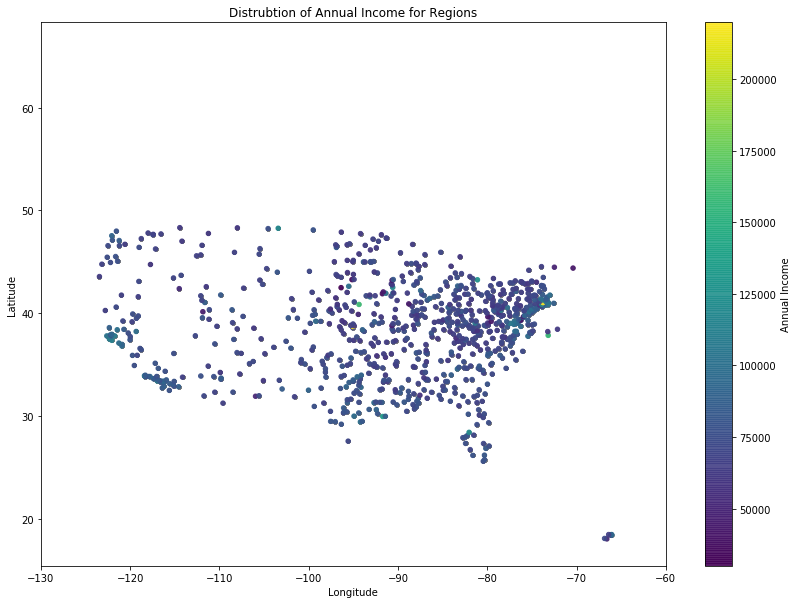

In [115]:
sample = geo_df

long_border = (-130, -60)
#lat_border = (30, 50)

# Round / bin the latitude and longitudes
sample['lat_bin'] = np.round(sample['Latitude'], 3)
sample['lng_bin'] = np.round(sample['Longitude'], 3)

# Average Average annual income for regions
gby_cols = ['lat_bin', 'lng_bin']

coord_stats = (sample.groupby(gby_cols)
               .agg({'annual_inc': 'mean'})
               .reset_index())

# Visualize the average annual income per region
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(sample['Longitude'].values,
                           sample['Latitude'].values,
                           color='grey', s=10, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['lng_bin'].values,
                          coord_stats['lat_bin'].values,
                          c=coord_stats['annual_inc'].values,
                          cmap='viridis', s=20, alpha=0.9)

cbar1 = fig.colorbar(scatter_cmap)
ax.set_xlim(long_border)
#ax.set_ylim(lat_border)
cbar1.set_label("Annual Income")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Distrubtion of Annual Income for Regions')
plt.axis('on');

plt.savefig("Average Annual Income for Zip Code Regions.png")


I took the average loan amount for each zip code base on the first three digits of the zip code again and graphed it based on the longitude and latitude. It seems like most of the loan amount are between $10,000 to $20,000. The loan amount seems to be evenly distributed based on the geographical location. This was interesting to see since the annual income vary between regions and I thought the loan amount with follow a similar distribution as the annual income.

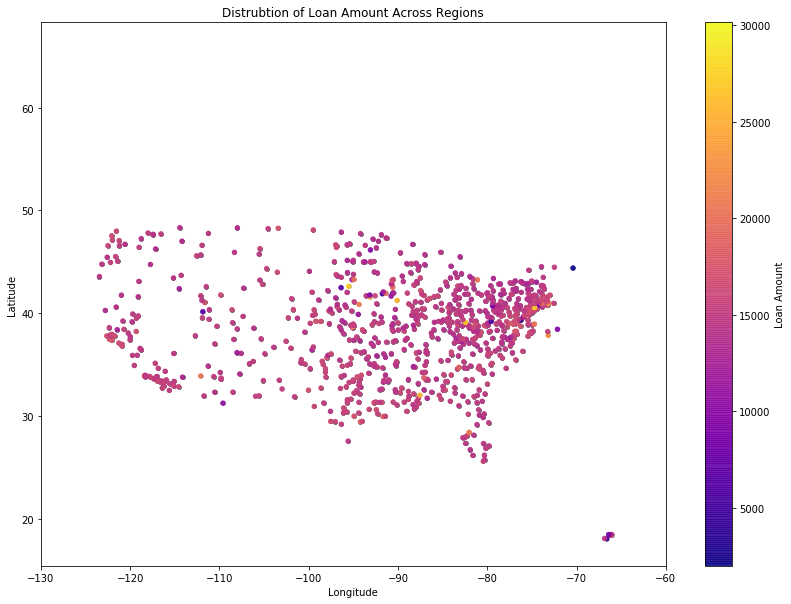

In [116]:
# Average Average loan amount for regions
gby_cols = ['lat_bin', 'lng_bin']

coord_stats = (sample.groupby(gby_cols)
               .agg({'loan_amnt': 'mean'})
               .reset_index())

# Visualize the average loan amount per region
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(sample['Longitude'].values,
                           sample['Latitude'].values,
                           color='grey', s=10, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['lng_bin'].values,
                          coord_stats['lat_bin'].values,
                          c=coord_stats['loan_amnt'].values,
                          cmap='plasma', s=20, alpha=0.9)

cbar2 = fig.colorbar(scatter_cmap)
ax.set_xlim(long_border)
#ax.set_ylim(lat_border)
cbar2.set_label("Loan Amount")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Distrubtion of Loan Amount Across Regions')
plt.axis('on');
plt.savefig("Average Loan Amount Across Zip Code Regions.png")
plt.show()

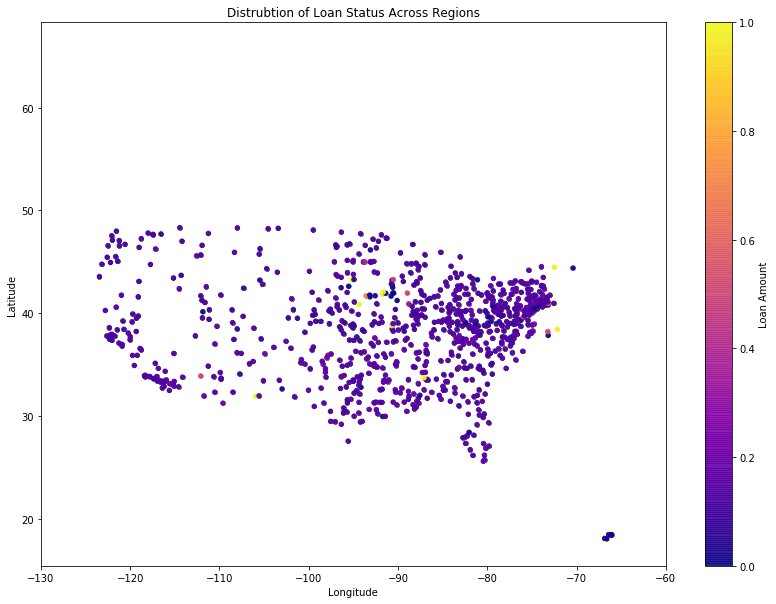

In [108]:
#Loan Status based on region 

# Average Average loan amount for regions
gby_cols = ['lat_bin', 'lng_bin']

coord_stats = (sample.groupby(gby_cols)
               .agg({'loan_status': 'mean'})
               .reset_index())

# Visualize the average loan amount per region
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(sample['Longitude'].values,
                           sample['Latitude'].values,
                           color='grey', s=10, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['lng_bin'].values,
                          coord_stats['lat_bin'].values,
                          c=coord_stats['loan_status'].values,
                          cmap='plasma', s=20, alpha=0.9)

cbar2 = fig.colorbar(scatter_cmap)
ax.set_xlim(long_border)
#ax.set_ylim(lat_border)
cbar2.set_label("Loan Amount")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Distrubtion of Loan Status Across Regions')
plt.axis('on');
plt.savefig("Loan Status Across Zip Code Regions.png")
plt.show()

In [114]:
#transform the data to visualize how home ownership varies for regions
home = merged_df.loc[:, ['zip_code','home_ownership_ANY',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status',
 'pymnt_plan', 'Longitude', 'Latitude']]

home['home'] = 0
home.loc[home['home_ownership_OWN'] == 1, 'home'] = 1
home.loc[home['home_ownership_RENT'] == 1, 'home'] = 2
home.loc[home['home_ownership_MORTGAGE'] == 1, 'home'] = 3
home.loc[home['home'] == 0, 'home'] = 4


,zip_code,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status,pymnt_plan,Longitude,Latitude,home
0,109,0,0,0,0,0,1,0,0,-74.003047,41.380497,2
1,713,0,1,0,0,0,0,1,0,-92.029721,31.311491,3
2,490,0,1,0,0,0,0,1,0,-85.245622,42.264694,3
3,985,0,1,0,0,0,0,1,0,-122.481007,46.561400,3
4,212,0,1,0,0,0,0,0,0,-75.826191,39.744593,3


I grouped each data point base on the zip code and found the mode of the type of home ownership representative of each group of zip codes and graphed it base on the longitude and latitude. Most of the zip codes have a higher majority of renters or individuals paying mortgage than homeowners. The zip codes with majority of renters are concentrated near metropolitan areas such as the Bay Area , Los Angeles, and New York City.  

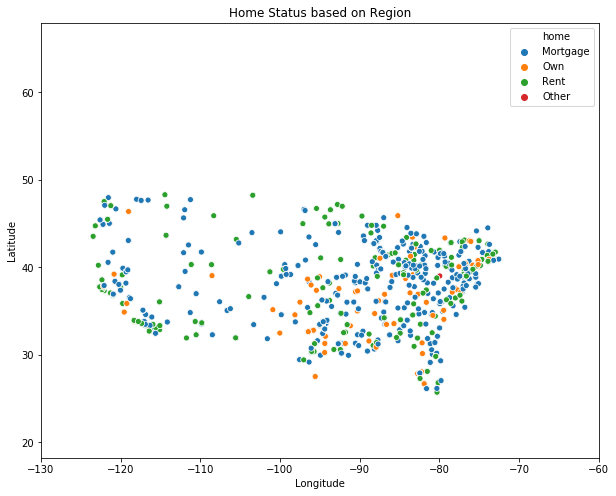

In [106]:
#home2 = home.sample(2000)
long_border = (-130, -60)
lat_border = (20, 60)

ax.set_xlim(long_border)
ax.set_ylim(lat_border)


#plt.figure(figsize=(14,8))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))

home_ownership = sns.scatterplot(y ='Latitude', x ='Longitude', hue = 'home', data = home2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Home Status based on Region")
ax.set_xlim(long_border)
plt.savefig("Home Ownership Across Zip Code Regions.png")
plt.show()

Split the data into training and testing sets. Also drop some columns to train the models.

In [57]:
lst = [ 'loan_amnt','funded_amnt','funded_amnt_inv','installment',
'int_rate','annual_inc','tot_hi_cred_lim','chargeoff_within_12_mths',
'total_pymnt','pub_rec_bankruptcies','dti','delinq_2yrs','grade_A','grade_B',
'grade_C','grade_D','grade_E','grade_F','grade_G', 'term_ 36 months',
'term_ 60 months','home_ownership_ANY','home_ownership_MORTGAGE',
'home_ownership_NONE','home_ownership_OTHER','home_ownership_OWN',
'home_ownership_RENT','verification_status','pymnt_plan','zip_code',
'term','emp_length','mths_since_last_delinq','issue_d','earliest_cr_line',
'loan_status']

#df_train = df.drop(['emp_title', 'addr_state', 'purpose'], axis = 1)
df_train = df.loc[:, lst]
df_train = df_train.fillna(0)
#df_train = df_train.sample(500000)
df_Y = df_train['loan_status']

df_train.drop(['loan_status'], axis = 1)
df_train = pd.get_dummies(df_train)

X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_Y, test_size=0.33, random_state=42) 

## Silhouette Score an Elbow Method

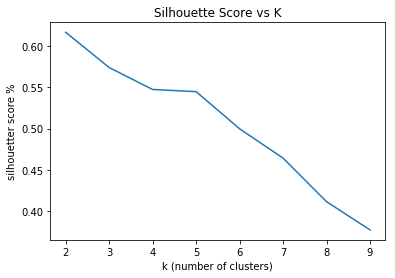

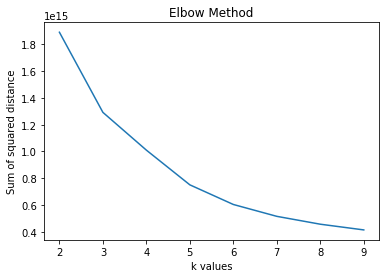

In [62]:
sample = X_train.sample(100000)
kes = list(range(2,10))
scores = []
ssmean = []

for k in kes:
  kmean = KMeans(n_clusters=k, random_state=0).fit(sample)
  labels = kmean.labels_
  s = silhouette_score(sample, labels)
  scores.append(s)
  kmean.fit(sample)
  ssmean.append(kmean.inertia_)

plt.plot(kes, scores)
plt.ylabel("silhouetter score %")
plt.xlabel("k (number of clusters)")
plt.title("Silhouette Score vs K")
plt.show()


plt.plot(kes, ssmean)
plt.xlabel("k values")
plt.ylabel("Sum of squared distance")
plt.title("Elbow Method")

plt.show()

## K Means and KNN Training on Bias Data

In [63]:
Kmean = KMeans(n_clusters= 2, random_state=0)
Kmean.fit(X_train, Y_train)

y_predkmean = Kmean.predict(X_train)
print('Kmean Training data accuracy', float(accuracy_score(y_predkmean, Y_train))*100, '%')

y_predtest = Kmean.predict(X_test)
print('Kmean Testing data accuracy', float(accuracy_score(y_predtest, Y_test))*100, '%')

TP = np.sum((Y_test == y_predtest) & (Y_test == 1))
print('True positive', TP / len(Y_test))

TN = np.sum((Y_test == y_predtest) & (Y_test == 0)) 
print('True Negative', TN / len(Y_test))

FP = np.sum(y_predtest == 1) - TP
print('False Positive', FP / len(Y_test))

FN = np.sum(y_predtest == 0) - TN
print('False Negative', FN / len(Y_test))

Kmean Training data accuracy 32.49528786626455 %
Kmean Testing data accuracy 32.40908590722969 %
True positive 0.11014953985509345
True Negative 0.21394131921720344
False Positive 0.6510340953186264
False Negative 0.02487504560907664


In [13]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier()

parameters = {"n_neighbors": [x for x in range(1, 2)],
             "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'], 
             }
#Knn = GridSearchCV(estimator = Knn, param_grid = parameters, cv = 2, scoring = "accuracy")
Knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
scores = cross_val_score(Knn, X_train, Y_train, cv=5)
scores

array([0.86470884, 0.86384901, 0.8648082 , 0.86433395, 0.86435891])

In [15]:
y_predknn = Knn.predict(X_train)
print('Knn Training data accuracy', float(accuracy_score(y_predknn, Y_train))*100, '%')

y_predtest = Knn.predict(X_test)
print('Knn Testing data accuracy', float(accuracy_score(y_predtest, Y_test))*100, '%')

TP = np.sum((Y_test == y_predtest) & (Y_test == 1))
print('True positive', TP / len(Y_test))

TN = np.sum((Y_test == y_predtest) & (Y_test == 0)) 
print('True Negative', TN / len(Y_test))

FP = np.sum(y_predtest == 1) - TP
print('False Positive', FP / len(Y_test))

FN = np.sum(y_predtest == 0) - TN
print('False Negative', FN / len(Y_test))

Knn Training data accuracy 89.76174396372639 %
Knn Testing data accuracy 86.47017600759862 %
True positive 0.028203784250244696
True Negative 0.8364979758257415
False Positive 0.028477438710088437
False Negative 0.1068208012139254


## K Means and KNN Training on Unbiased Data

Used the ethical features to train the models. Drop the job, zip, state, home ownership, and dti features to train the models.

In [16]:
ethical = ['dti', 'annual_inc', 'home_ownership_ANY','home_ownership_MORTGAGE',
'home_ownership_NONE','home_ownership_OTHER','home_ownership_OWN',
'home_ownership_RENT', 'zip_code']

X_trainEth = X_train.drop(ethical, axis = 1)
X_testEth = X_test.drop(ethical, axis = 1)


In [17]:

KmeanEthical = KMeans(n_clusters=2, random_state=0)
KmeanEthical.fit(X_trainEth, Y_train)

y_pred = KmeanEthical.predict(X_trainEth)
print('Kmean Training data accuracy', float(accuracy_score(y_pred, Y_train))*100, '%')

y_predtest = KmeanEthical.predict(X_testEth)
print('Kmean Testing data accuracy', float(accuracy_score(y_predtest, Y_test))*100, '%')

TP = np.sum((Y_test == y_predtest) & (Y_test == 1))
print('True positive', TP / len(Y_test))

TN = np.sum((Y_test == y_predtest) & (Y_test == 0)) 
print('True Negative', TN / len(Y_test))

FP = np.sum(y_predtest == 1) - TP
print('False Positive', FP / len(Y_test))

FN = np.sum(y_predtest == 0) - TN
print('False Negative', FN / len(Y_test))



Kmean Training data accuracy 67.1317350707551 %
Kmean Testing data accuracy 67.21706445503669 %
True positive 0.025526603846799837
True Negative 0.6466440407035671
False Positive 0.21833137383226284
False Negative 0.10949798161737025


In [18]:
KnnEthical = KNeighborsClassifier()

parameters = {"n_neighbors": [x for x in range(1, 2)],
             "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'], 
             }
#Knn = GridSearchCV(estimator = Knn, param_grid = parameters, cv = 2, scoring = "accuracy")
KnnEthical.fit(X_trainEth, Y_train)

y_pred = KnnEthical.predict(X_trainEth)
print('Knn Training data accuracy', float(accuracy_score(y_pred, Y_train))*100, '%')

y_predtest = KnnEthical.predict(X_testEth)
print('Knn Testing data accuracy', float(accuracy_score(y_predtest, Y_test))*100, '%')

TP = np.sum((Y_test == y_predtest) & (Y_test == 1))
print('True positive', TP / len(Y_test))

TN = np.sum((Y_test == y_predtest) & (Y_test == 0)) 
print('True Negative', TN / len(Y_test))

FP = np.sum(y_predtest == 1) - TP
print('False Positive', FP / len(Y_test))

FN = np.sum(y_predtest == 0) - TN
print('False Negative', FN / len(Y_test))

Knn Training data accuracy 91.36247879272388 %
Knn Testing data accuracy 88.57659139479796 %
True positive 0.03931357615702264
True Negative 0.846452337790957
False Positive 0.01852307674487296
False Negative 0.09571100930714745


## Clustering Algorithm Conclusion


I use the 36 features out of the 145 features to train K-Means and KNN models to predict that status of the loan.  I split the dataset into ⅔ training set and ⅓ as the testing set.  I sampled 100,000 data points from the the training set to find the optimal number of clusters for K-Means using silhouette score and elbow method. Both the silhouette score and elbow method had 2 cluster as the optimal number of clusters. I used the training set with 2 cluster as a hyperparameter to train a K-Means model. The K-Means accuracy on the bias data was 32%. The accuracy was really low and surprising because 86% of the loan status are zeros. I then trained a new K-Means model using the same training and testing subset  but I dropped all of the demographic/bias features from the training set and testing set. Surprisingly, the unbiased model had a 67% accuracy when predicting the testing set. The unbiased K-Means model had 35% greater accuracy at predicting the loan status for the test set compared to the model trained with the demographic/bias features. 



Models | Bias K Means Model | Unbiased K Means Model 
---      | --- | --- 
Training Set Accuracy | 32.49%  | 67.13% 
Testing Set Accuracy         | 32.41%  | 67.13%   
True Positive           | 11.01%  | 2.55%   
True Negative         | 23.49%  | 64.66%   
False Positive         | 65.10%  | 21.83%  
False Negative         | 2.48%  | 10.95%   

For KNN models, I also use the same training and testing set as for the K-Means models. I sampled 100,000 data points from the training dataset for GridSearchCV to find the optimal hyperparameters. The optimal hyperparameters ended up being 5 neighbors, leaf size of 30, and the “auto” algorithm. I also did a 5 fold cross validation and the average accuracy were 86%. The KNN model that was trained with the 36 selected features had 86.4% accuracy when predicting the testing set. I then trained another KNN model but with the demographic/bias features dropped but using the same hyperparameters. The unbiased KNN model had an accuracy of 88.5% when predicting the testing subset. 






Models | Bias KNN Model | Unbiased KNN Model 
---      | --- | --- 
Training Set Accuracy | 89.76 91.36%  | 91.36% 
Testing Set Accuracy         | 86.47%  | 88.57%   
True Positive           | 2.82%  | 3.93%   
True Negative         | 83.65%  | 84.64%   
False Positive         | 2.84%  | 1.85%  
False Negative         | 10.68%  | 9.57%  

  
Overall, both clustering algorithms improved when trained and predicting our datasets lacking demographic features than when the datasets contained demographic features. It seems possible to have unbiased clustering models to predict if an individual will default or be late on their loan payment without using demographic data.
